In [1]:
import keras
import glob
import cv2
import os
import gc
import pickle
import numpy as np
import pandas as pd
import tqdm
from models.SegNet import *
from models.U_net import *
from models.DeeplabV3Plus import *
from models.AutoEncoder import *
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD
from keras.metrics import MeanIoU
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import  compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

## 載入照片與標籤

In [2]:
# 調整圖片大小，如果有需要
SIZE_X = 256 
SIZE_Y = 256
n_classes= 4  # 分割的類別數量=岩石分類+背景(1)=n_classes
random_number = 0
batch_size = 16
epochs_num = 300
model_name = f'random_{random_number}.h5'

In [3]:
# 捕捉訓練圖片信息，以列表形式保存
train_images = []

for img_path in tqdm.tqdm(glob.glob('../raw_data/core_image/*.png'), desc="正在載入照片"):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    train_images.append(img)
    # 提取文件名並附加到列表中
    image_name = os.path.basename(img_path)

# 將列表轉換為陣列，以供機器學習處理        
train_images = np.array(train_images)

正在載入照片: 100%|██████████| 3943/3943 [01:11<00:00, 55.32it/s] 


In [4]:
# 捕捉遮罩/標籤信息，以列表形式保存
train_masks = [] 
for mask_path in tqdm.tqdm(glob.glob(f'../raw_data/{int(n_classes)-1}_label/*.png'), desc="正在載入標籤"):
    mask = cv2.imread(mask_path, 0)
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
    train_masks.append(mask)
        
# 將列表轉換為陣列，以供機器學習處理          
train_masks = np.array(train_masks)  # 這是載入照片及標籤的程式

正在載入標籤:   0%|          | 0/3943 [00:00<?, ?it/s]

正在載入標籤: 100%|██████████| 3943/3943 [00:05<00:00, 716.39it/s] 


In [5]:
print("train image shape: " + str(train_images.shape))
print("train mask shape: " + str(train_masks.shape))

train image shape: (3943, 256, 256, 3)
train mask shape: (3943, 256, 256)


## 訓練/測試集

In [6]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped.ravel())
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

print(train_masks_encoded_original_shape.shape)
np.unique(train_masks_encoded_original_shape)

(3943, 256, 256)


array([0, 1, 2, 3], dtype=int64)

In [7]:
#train_images = np.expand_dims(train_images, axis=3)
train_images_norm = train_images/255

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
###del
del train_masks_encoded_original_shape,train_masks_reshaped
gc.collect()

9

In [8]:
X_train, X_test, y_train, y_test= train_test_split(
    train_images_norm, 
    train_masks_input, 
    test_size=0.2, 
    random_state=random_number
)
# Print shapes of the sets
print("Training set shape: ", X_train.shape)
print("Validation set shape: ", X_test.shape)

Training set shape:  (3154, 256, 256, 3)
Validation set shape:  (789, 256, 256, 3)


In [9]:
del train_images_norm, train_masks_input
gc.collect()

0

In [11]:
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

Class values in the dataset are ...  [0 1 2 3]


In [11]:
class_weights =compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(train_masks_reshaped_encoded),
                                        y = train_masks_reshaped_encoded )                                    
class_weights = class_weights.tolist()
class_weights

[1.0230623010003006, 0.7541217329575782, 1.6451587108611456, 0.91856678293266]

In [12]:
# 將 class_weights 寫入到.pkl檔案
with open(f'./random_number_{random_number}.pkl', 'wb') as f:
    pickle.dump(class_weights, f)

print("class_weights 已保存到 class_weights.pkl 檔案中。")

class_weights 已保存到 class_weights.pkl 檔案中。


---

In [10]:
# 从文件中加载 class_weights 对象
with open(f'./random_number_{random_number}.pkl', 'rb') as f:
    class_weights = pickle.load(f)
class_weights

[1.0230623010003006, 0.7541217329575782, 1.6451587108611456, 0.91856678293266]

In [12]:
#使用U-Net
# model =  U_NET(n_classes= n_classes, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)
# model.compile(optimizer='adam', 
#               loss= weightedLoss(keras.losses.categorical_crossentropy, class_weights), 
#               metrics=['accuracy'])
# model.summary()
#使用segNet
# model =  segnet(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)
# model.compile(optimizer=SGD(learning_rate=0.001, 
#                                 momentum=0.9, 
#                                 decay=0.0005, 
#                                 nesterov=False), 
#                                 loss='categorical_crossentropy', 
#                                 metrics=['accuracy']) # type: ignore
# model.summary()
#使用autoencoder
model = AutoEncoder(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       295168

In [14]:
learning_rate_function = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.6,
                                            min_lr=0.00001)
earlystop = EarlyStopping(monitor='val_loss',
                          mode='min',
                          #min_delta=0.001,
                          patience=60,
                          verbose=1)
modelcheck = ModelCheckpoint(model_name,
                             monitor='val_loss',
                             mode='min',
                             verbose=1,
                             save_best_only=True)

In [15]:
history = model.fit(X_train, 
                 y_train_cat, 
                 epochs= epochs_num, 
                 batch_size= batch_size, 
                 validation_data= (X_test, y_test_cat), 
                 verbose=1, 
                 shuffle=False,
                 callbacks=[learning_rate_function, earlystop, modelcheck])

Epoch 1/300
198/198 [==============================] - ETA: 0s - loss: 0.9031 - accuracy: 0.6033
Epoch 1: val_loss improved from inf to 1.15627, saving model to random_0.h5
198/198 [==============================] - 26s 98ms/step - loss: 0.9031 - accuracy: 0.6033 - val_loss: 1.1563 - val_accuracy: 0.5964 - lr: 0.0010
Epoch 2/300
197/198 [============================>.] - ETA: 0s - loss: 0.7289 - accuracy: 0.7066
Epoch 2: val_loss improved from 1.15627 to 0.74352, saving model to random_0.h5
198/198 [==============================] - 16s 81ms/step - loss: 0.7286 - accuracy: 0.7068 - val_loss: 0.7435 - val_accuracy: 0.7029 - lr: 0.0010
Epoch 3/300
197/198 [============================>.] - ETA: 0s - loss: 0.6450 - accuracy: 0.7405
Epoch 3: val_loss improved from 0.74352 to 0.65636, saving model to random_0.h5
198/198 [==============================] - 15s 78ms/step - loss: 0.6447 - accuracy: 0.7406 - val_loss: 0.6564 - val_accuracy: 0.7317 - lr: 0.0010
Epoch 4/300
197/198 [==============

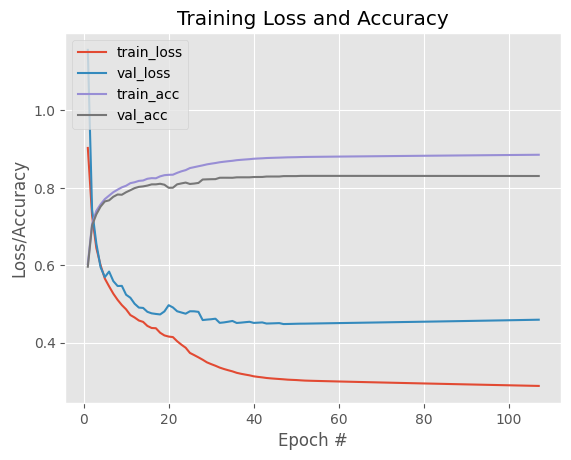

In [16]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = range(1, len(history.history['loss']) + 1)
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig(f'./U_net_Loss&Accuracy{random_number}.png')

--- 

## 載入模型

In [13]:
model.load_weights(f'./{model_name}')
############################################################

In [14]:
#Evaluate the model
# evaluate model
_, acc = model.evaluate(X_train, y_train_cat)
print("Accuracy is = ", (acc * 100.0), "%")

99/99 [==============================] - 10s 58ms/step - loss: 0.3053 - accuracy: 0.8785
Accuracy is =  87.85374760627747 %


## 驗證集預測結果

In [15]:
##################################
#IOU
val_y_pred=model.predict(X_test)
val_y_pred_argmax=np.argmax(val_y_pred, axis=3)

25/25 [==============================] - 2s 71ms/step


In [16]:
#Using built in keras function

IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], val_y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.6946981


In [17]:
#Using built in keras function
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], val_y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class0_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3]+ values[1,0]+ values[2,0]+ values[3,0])
class1_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3]+ values[0,1]+ values[2,1]+ values[3,1])
class2_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3]+ values[0,2]+ values[1,2]+ values[3,2])
class3_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2]+ values[0,3]+ values[1,3]+ values[2,3])
#class4_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2]+ values[4,3]+ values[0,4]+ values[1,4]+ values[2,4]+ values[3,4])


print("IoU for class0 is: ", class0_IoU)
print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
#print("IoU for class4 is: ", class4_IoU)

Mean IoU = 0.6946981
[[11820404.   371123.   141308.   288315.]
 [  315325. 12963684.  1693126.   562799.]
 [  181447.  2610092.  4599400.  1371787.]
 [  213516.   380220.   640204. 13555154.]]
IoU for class0 is:  0.88665634
IoU for class1 is:  0.68604106
IoU for class2 is:  0.4092953
IoU for class3 is:  0.7967997


In [18]:
import itertools
def plot_confusion_matrix(cm, classes,name:str, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'confusion_matrix_{name}.png')

              precision    recall  f1-score   support

  background     0.9433    0.9366    0.9399  12621150
         mud     0.7941    0.8345    0.8138  15534934
        sand     0.6502    0.5249    0.5809   8762726
      gravel     0.8591    0.9166    0.8869  14789094

    accuracy                         0.8304  51707904
   macro avg     0.8117    0.8031    0.8054  51707904
weighted avg     0.8247    0.8304    0.8260  51707904



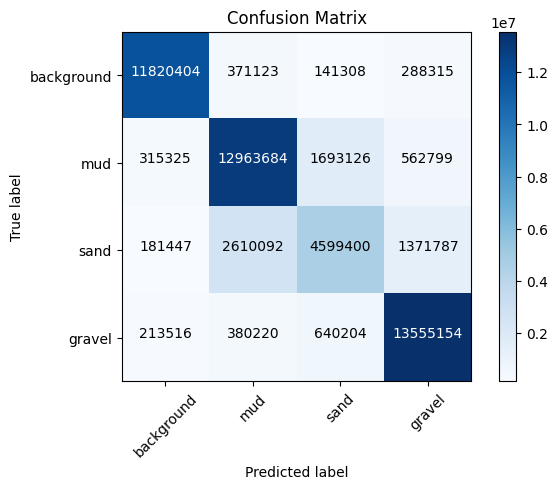

In [19]:
values_cm = int_array = np.array(IOU_keras.get_weights()).astype(int)
values_cm  = values_cm .reshape(n_classes, n_classes)
target_names = ["background","mud","sand","gravel"]
plot_confusion_matrix(values_cm , target_names,f'{model_name}')
classification_report_test = classification_report(y_test[:,:,:,0].ravel(),
                                                   val_y_pred_argmax.ravel(),
                                                    target_names=target_names, 
                                                    digits = 4)
print(classification_report_test)#會輸出precision、recall與f1-score。

### Testing dataset 預測結果

In [20]:
# 捕捉訓練圖片信息，以列表形式保存
test_images = []


for img_path in glob.glob('../raw_data/testing_dataset/core_image/*.png'):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    test_images.append(img)
    # 提取文件名並附加到列表中
    image_name = os.path.basename(img_path)

# 將列表轉換為陣列，以供機器學習處理        
test_images = np.array(test_images)

# 捕捉遮罩/標籤信息，以列表形式保存
test_masks = [] 
name_list = []

for mask_path in glob.glob(f'../raw_data/testing_dataset/{int(n_classes)-1}_label/*.png'):
    # 获取文件名并添加到列表中
    name = os.path.basename(mask_path)
    name_list.append(name)
    mask = cv2.imread(mask_path, 0)
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
    test_masks.append(mask)
        
# 將列表轉換為陣列，以供機器學習處理          
test_masks = np.array(test_masks)  # 這是載入照片及標籤的程式

In [21]:
print("test image shape: " + str(test_images.shape))
print("test mask shape: " + str(test_masks.shape))

test image shape: (4, 256, 256, 3)
test mask shape: (4, 256, 256)


In [22]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
labelencoder = LabelEncoder()
n, h, w = test_masks.shape
test_masks_reshaped = test_masks.reshape(-1,1)
test_masks_reshaped_encoded = labelencoder.fit_transform(test_masks_reshaped.ravel())
test_masks_encoded_original_shape = test_masks_reshaped_encoded.reshape(n, h, w)

print(test_masks_encoded_original_shape.shape)
np.unique(test_masks_encoded_original_shape)

(4, 256, 256)


array([0, 1, 2, 3], dtype=int64)

In [23]:
test_images_norm = test_images/255

test_masks_input = np.expand_dims(test_masks_encoded_original_shape, axis=3)

In [24]:
##################################
#IOU
y_pred=model.predict(test_images_norm)
y_pred_argmax=np.argmax(y_pred, axis=3)

1/1 [==============================] - 0s 410ms/step


In [25]:
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_masks_input[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.6861122


In [26]:
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_masks.ravel(), y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class0_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3]+ values[1,0]+ values[2,0]+ values[3,0])
class1_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3]+ values[0,1]+ values[2,1]+ values[3,1])
class2_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3]+ values[0,2]+ values[1,2]+ values[3,2])
class3_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2]+ values[0,3]+ values[1,3]+ values[2,3])
#class4_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2]+ values[4,3]+ values[0,4]+ values[1,4]+ values[2,4]+ values[3,4])


print("IoU for class0 is: ", class0_IoU)
print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
#print("IoU for class4 is: ", class4_IoU)

Mean IoU = 0.6861122
[[6.6387e+04 4.0000e+02 9.0000e+00 2.9800e+02]
 [3.4100e+02 1.4364e+05 9.6380e+03 8.0730e+03]
 [5.0000e+01 5.7920e+03 8.6260e+03 3.7200e+02]
 [3.2000e+01 9.6400e+02 1.6860e+03 1.5836e+04]]
IoU for class0 is:  0.9832635
IoU for class1 is:  0.850706
IoU for class2 is:  0.32957628
IoU for class3 is:  0.5809031


              precision    recall  f1-score   support

  background     0.9937    0.9895    0.9916     67094
         mud     0.9525    0.8884    0.9193    161692
        sand     0.4322    0.5813    0.4958     14840
      gravel     0.6443    0.8552    0.7349     18518

    accuracy                         0.8945    262144
   macro avg     0.7557    0.8286    0.7854    262144
weighted avg     0.9118    0.8945    0.9008    262144



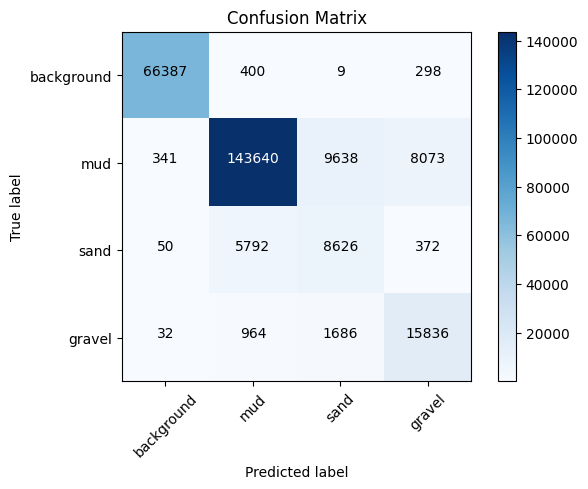

In [27]:
values_cm = int_array = np.array(IOU_keras.get_weights()).astype(int)
values_cm  = values_cm .reshape(n_classes, n_classes)
target_names = ["background","mud","sand","gravel"]
plot_confusion_matrix(values_cm , target_names,f'testing_{model_name}')
classification_report_test = classification_report(test_masks.ravel(),
                                                   y_pred_argmax.ravel(),
                                                    target_names=target_names, 
                                                    digits = 4)
print(classification_report_test)#會輸出precision、recall與f1-score。

----

## 寫入excel

In [ ]:
val_report = classification_report(y_test[:,:,:,0].ravel(),
                                val_y_pred_argmax.ravel(), 
                                target_names=target_names, 
                                digits = 4,
                                output_dict=True)
val_df = pd.DataFrame(val_report).transpose()
val_df

In [ ]:
new_row_data = {}
for col in val_df.columns:
    new_row_data[col] = 'validation'

new_row = pd.DataFrame(new_row_data, index=[0])
new_row

In [ ]:
val_df = pd.concat([new_row, val_df], ignore_index=False, axis=0)
val_df

In [ ]:
test_report = classification_report(test_masks.ravel(),
                                   y_pred_argmax.ravel(),
                                    target_names=target_names, 
                                    digits = 4,
                                    output_dict=True)

In [ ]:
new_row_data = {}
for col in val_df.columns:
    new_row_data[col] = 'testing'

new_row = pd.DataFrame(new_row_data, index=[0])

In [ ]:
test_df = pd.DataFrame(test_report).transpose()

In [ ]:
test_df = pd.concat([new_row, test_df], ignore_index=False)
test_df

In [ ]:
df = pd.concat([val_df, test_df], ignore_index=False)
df

In [ ]:
# 检查文件是否存在
if not os.path.exists('./segnet_result.xlsx'):
    # 将 DataFrame 保存为 Excel 文件
    df.to_excel('./segnet_result.xlsx', sheet_name=f'random_{random_number}')
else:
    # 如果文件已存在，则不执行任何操作
    pass

In [ ]:
with pd.ExcelWriter('./segnet_result.xlsx', engine='openpyxl', mode='a') as writer:
    # 寫入 DataFrame 到現有的 Excel 檔案的指定工作表中
    df.to_excel(writer, index=True, sheet_name=f'random_{random_number}')